# Lab - Data Collection - Training
## E6692 Spring 2022

VERSION WITH SOLUTIONS

In part 2 of this lab we will be collecting and labeling data for a regression task with the Logitech webcam, training regression models, and performing live inference through the webcam with the trained models. We will define and train a custom CNN regression model that inherits from the PyTorch **nn.Module**, as well as fine tuning a pretrained ResNet model. The process for labeling the regression data is slightly different from part 1. See **Label Regression Data** and the docstring of **regression_labeling.py** for details.

To use the webcam in this lab you need to specify it when mounting the docker by adding the tag `--device /dev/video0`. Additionally, you should include a data volume for storing images. We recommended that you have a `data` folder in the root directory of your Jetson Nano, and subsequent lab folders within this data folder. For example, the data for this lab would be stored in `~/data/Lab-DataCollectionAndTraining`. Then you can include the external data directory when mounting the docker with `--volume ~/data/Lab-DataCollectionAndTraining:/docker/path/to/lab`.


## Part 2.1: Data Collection for Regression

In this part we collect and label image data for regression using the Jetson Nano webcam.

In [1]:
# import modules
import os
import torch
import torchvision
import torchvision.transforms as T
import random
import matplotlib.pyplot as plt

from utils.data_collection import DATA_SHAPE
from utils.datasets import RegressionDataset, get_label_dict
from utils.data_collection import collect_regression_data
from utils.models import CustomRegression
from utils.training import train_regression, plot_loss_and_accuracy
from utils.live_inference import live_regression

# define paths
data_path = './data/regression'
if not os.path.exists(data_path):
    os.makedirs(data_path)

labeled_data_path = os.path.join(data_path, 'labeled')
if not os.path.exists(labeled_data_path):
    os.makedirs(labeled_data_path)
    
unlabeled_data_path = os.path.join(data_path, 'unlabeled')
if not os.path.exists(unlabeled_data_path):
    os.makedirs(unlabeled_data_path)

train_path = os.path.join(labeled_data_path, 'train')
if not os.path.exists(train_path):
    os.makedirs(train_path)

val_path = os.path.join(labeled_data_path, 'val')
if not os.path.exists(val_path):
    os.makedirs(val_path)
    
models_path = './models'
if not os.path.exists(models_path):
    os.makedirs(models_path)

labels_path = './regression_labels.txt'

device = torch.device('cuda')
print("GPU name: ", torch.cuda.get_device_name(0))

# reload modules every 2 seconds to see changes in notebook
%load_ext autoreload
%autoreload 2

%matplotlib inline

GPU name:  NVIDIA Tegra X1


### Define A Regression Problem

Define the regression problem by enumerating the regression classes our model will locate in an image. For example, image regression classes include left/right eye location, nose location, body keypoints, fingertip locations, etc. Define your own regression classes (at least 2), but keep in mind the limitations of collecting data through the webcam (relatively low resolution, confined to objects in the lab, time needed to label) and the capacity of models you are able to run on the Jetson Nano. 


In [2]:
# TODO: define the names of regression classes that will be predicted and a name for the regression task. 
# Replace the following list elements with your regression classes

regression_class_names = ['phone', 'bottle']
regression_task_name = 'ThingsOnDesk'


### Collect, Preprocess, and Label Data

TODO: complete the methods of the class **RegressionDataset** in **utils/datasets.py**. This class inherits from **torch.utils.data.Dataset** to give us compatibility between our custom classification dataset and **torch.utils.data.DataLoader** functionality. 

#### Data Augmentation

To make our custom dataset more robust, we will apply data augmentation transforms.

TODO: visit the documentation page for **[torchvision.transforms](https://pytorch.org/vision/main/auto_examples/plot_transforms.html)** to familiarize yourself with data augmentation transforms. Then use **torchvision.transforms.Compose()** to define a data augmentation pipeline.

NOTE: data augmentation for regression can run into similar issues as for classification. For example, if you are applying spatial transformations to your images, you would need to apply the same spatial transforms to the regression coordinates. Keep this in mind when choosing augmentations.


In [3]:
# TODO: Use torchvision.transforms.Compose() to define a data augmentation pipeline

transforms = T.Compose([
    
    # insert data augmentations here
    
    T.Resize(DATA_SHAPE),
    T.ToTensor(), # don't modify Resize(), ToTensor() or Normalize().
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    T.ColorJitter(brightness=.5, hue=.3),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    T.RandomRotation(degrees=(0, 30))
])


SyntaxError: invalid syntax (<ipython-input-3-35996aa4cc0d>, line 10)

#### Discuss the differences between data augmentation for classification and regression.

TODO: your answer here.



In [ ]:
# TODO: define a training set and a validation set with the ClassificationDataset class.
train_path = 'data/regression/labeled/train'
val_path = 'data/regression/labeled/val'
unlabeled_data_path = './data/regression/unlabeled/' + regression_task_name

train_set = RegressionDataset(train_path, regression_class_names, regression_task_name, transforms=None)
val_set = RegressionDataset(val_path, regression_class_names, regression_task_name, transforms=None)

#### Collect Data for Regression

Use the function **collect_regression_data()** in **utils/data_collection.py** to collect data for image regression. The labeling process for regression data is slightly different than for classification. Rather than collecting data class by class, we will collect a large set of images from the webcam, then transfer them to your local computer to label them with point and click. Point and click functionality is not readily available in headless mode with the Jetson Nano.

Similarly to the classification data collection function, you are welcome to make improvements or modifications to **collect_regression_data()**.

In [5]:
# TODO: use collect_regression_data() to collect training data
#       Save the images to the unlabeled data path

collect_regression_data(unlabeled_data_path)


Data collection finished.


#### Label Regression Data

Now that we have collected data for regression, we need to label it. To do this we will run the python script **regression_labeling.py** locally. Refer to the usage instructions in the doc string for details. 

TODO: Transfer the unlabeled images to your laptop using scp. Note that this requires dismounting the docker, and that you have saved the images in a volume outside of the docker. From a local terminal use the command `scp -r username@IP:~/Jetson Nano path/to/unlabeled /local/path/to/data` to transfer your unlabeled data from the Jetson Nano. Then run the following cell on your local machine to label the images you collected.

In [ ]:
# TODO: label your regression data locally with regression_labeling.py
# !python3 regression_labeling.py INSTRUCTOR TODO - UNCOMMENT

regression_labeling.py will generate a text file that contains the labels for the corresponding images. Once we have the labels file, we can populate the training and validation RegressionDatasets.

#### Populate RegressionDataset with Labeled Images

In [ ]:
# Split the unlabeled images randomly into a training and validation set. 

train_val_split = 0.8 # define train/val split

unlabled_image_names = os.listdir(unlabeled_data_path) # get list of unlabeled image names
unlabled_image_names = [i for i in unlabled_image_names if '.jpg' in i] # remove non-images
unlabled_length = len(unlabled_image_names) # get number of images

split_index = int(train_val_split * unlabled_length) # define split index
random.shuffle(unlabled_image_names) # randomly shuffle names

unlabled_train_names = unlabled_image_names[:split_index] # split into train and val based on index
unlabled_val_names = unlabled_image_names[split_index:]


In [ ]:
# TODO: use the RegressionDataset.populate_from_files() method to populate 
#       the regression datasets. Print the length of each to the cell output.

train_set.populate_from_files(unlabled_train_names, unlabeled_data_path, labels_path)
# TODO: use RegressionDataset.grid_visualization() to visualize the training 
#       and validation sets.
val_set.populate_from_files(unlabled_val_names, unlabeled_data_path, labels_path)


#### Discuss the appearance of the train and validation sets. What characteristics are important to observe in a regression dataset before training?

TODO: Your answer here.

## Part 2.2 Custom Image Regression Model Definition

Now that we have a dataset, we will define a convolutional neural network model for regression. We will use the [PyTorch functional API](https://pytorch.org/docs/stable/nn.functional.html) to construct a custom CNN regression model. Your model should have convolutional layers for learning features and fully connected layers for keypoint regression. The architecture of your model should be very similar to the classification model, except instead of classification the fully connected layers will be used to regress the keypoints. That means you will need twice as many outputs as regression classes (1 for X, 1 for Y).

TODO: Complete the class **CustomRegression** in **utils/models.py**. This class inherits from the [PyTorch nn.Module class](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which gives it many functionalities including automatic handling of parameter transfer to the GPU. You must redefine the **CustomRegression.forward()** method to define the forward pass of the model with your custom layers. 

NOTE: Keep in mind the limited memory resources of the Jetson Nano. You may experience issues (kernel dying, notebook freezing) if your model has too many parameters.

In [4]:
# Define instance of CustomRegression

num_regression_classes = len(regression_class_names) # get the number of classes (output shape)
model = CustomRegression(num_regression_classes) # initialize model
model.to(device) # transfer model to GPU


CustomRegression(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4608, out_features=32, bias=True)
    (17): ReLU()
    (18): Linear(in_features=32, out_features=4, bias=True)
    (19): ReLU()
  )
)

## Part 2.3 Custom Regression Model Training

Now we need to train the model on our custom regression dataset. TODO: complete the function **train_regression()** in **utils/training.py**. Use the comments as a guide, and refer to the [PyTorch training loop documentation](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=def%20train_one_epoch(epoch_index%2C%20tb_writer)%3A). Your training loop should save the model with the lowest validation loss score. 

NOTE: if you experience freezing or kernel dying, try reducing your batch size and defining a model with less parameters. 

In [11]:
# TODO: define model hyperparameters and use train_regression() to train 
#       your CNN regression model


batch_size = 8
epochs = 10
save_path = './models/regression_1_e10_b8.pth'
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4, momentum=0.9)

train_loss_hist, val_loss_hist = train_regression(model, device, train_set, val_set, batch_size, optimizer, epochs, save_path)

Epoch: 1
sample:72, train_loss:0.2368
sample:152, train_loss:0.2483
Train Loss:0.2529
Val Loss:0.1333
Best model saved.


Epoch: 2
sample:72, train_loss:0.2367
sample:152, train_loss:0.2482
Train Loss:0.2528
Val Loss:0.1331
Best model saved.


Epoch: 3
sample:72, train_loss:0.2366
sample:152, train_loss:0.2480
Train Loss:0.2527
Val Loss:0.1330
Best model saved.


Epoch: 4
sample:72, train_loss:0.2366
sample:152, train_loss:0.2479
Train Loss:0.2527
Val Loss:0.1330
Best model saved.


Epoch: 5
sample:72, train_loss:0.2365
sample:152, train_loss:0.2478
Train Loss:0.2526
Val Loss:0.1329
Best model saved.


Epoch: 6
sample:72, train_loss:0.2364
sample:152, train_loss:0.2478
Train Loss:0.2525
Val Loss:0.1328
Best model saved.


Epoch: 7
sample:72, train_loss:0.2364
sample:152, train_loss:0.2477
Train Loss:0.2525
Val Loss:0.1328
Best model saved.


Epoch: 8
sample:72, train_loss:0.2363
sample:152, train_loss:0.2476
Train Loss:0.2524
Val Loss:0.1328
Best model saved.


Epoch: 9
sample:72, trai

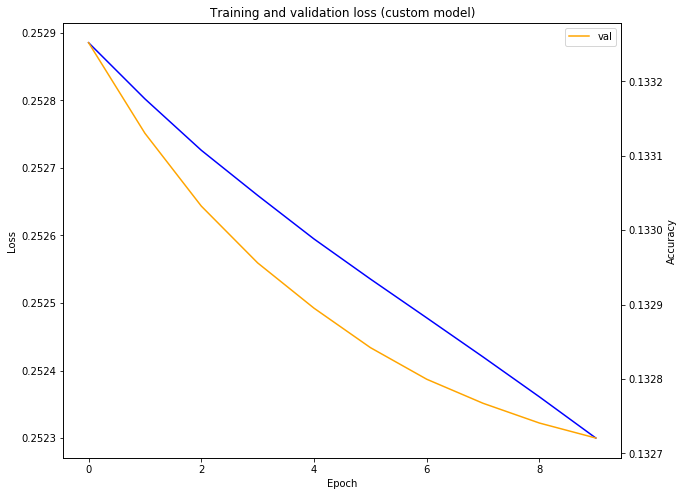

In [22]:
# TODO: plot the training and validation loss histories of your custom model separately
#       Don't forget proper axis labels and titles.
title = 'Training and validation loss (custom model)'
labels = ['train','val']
_, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

ax1.plot(train_loss_hist, color='blue', label=labels[0])
ax2.plot(val_loss_hist, color='orange', label=labels[1])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss(train)")
ax1.legend()
ax2.set_ylabel("Loss(val)")
ax2.legend()
# plt.legend()

plt.title(title)
plt.show()


### Outline the results of your custom regression training.

If you are not getting low validation accuracy you may need to collect more data, revise your model architecture, or adjust hyperparameters. Explain your process of improving the model's performance below.

TODO: Your answer here.

Firstly the kernel freezed, so I reduced the batch_size. The model is very easy to converge, so I enlarged dataset, add more layers to the model and reduced the learning rate.

## Part 2.4 Custom Regression Live Inference

We will now use the custom trained model to do live classification through the webcam. 

TODO: Complete the function **live_regression()** in **utils/live_inference.py**.

In [5]:
# model_save_path = './models/regression_1_e5_b8.pth'
model_save_path = './models/regression_1_e10_b4.pth'

live_regression(model_save_path, model, device, regression_class_names)

Loading model.
Video feed started.
[[0 0 0 0]] (1, 4)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Discuss the performance of the live inference. Is the model able to do inference fast enough for the feed to be real time? Is the regression accurate?

TODO: Not fast enough to be real time. Because the testing environment is slightly different with the dataset, so the regression is not very accurate

### Insert a screenshot of your custom model regression below.

TODO: insert custom model regression screenshot here.

## Part 2.5 Pretrained Regression Live Inference

In this part we repeat parts 1.2 - 1.4 with a [pretrained ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/). We have defined the pretrained PyTorch implementation below.

In [23]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512, 2 * len(regression_class_names))
resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# TODO: use train_regression() to fine tune ResNet18 for your dataset
batch_size = 2
epochs = 10
save_path = './models/regression_res_1_e10_b2.pth'
optimizer = torch.optim.SGD(resnet18.parameters(), lr=1e-3, momentum=0.9)

train_loss_hist, val_loss_hist = train_regression(resnet18, device, train_set, val_set, batch_size, optimizer, epochs, save_path)

Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


sample:18, train_loss:0.3840
sample:38, train_loss:0.5406
sample:58, train_loss:0.6418
sample:78, train_loss:0.6595
sample:98, train_loss:0.6640
sample:118, train_loss:0.6853
sample:138, train_loss:0.6689
sample:158, train_loss:0.7198
sample:178, train_loss:0.6812
sample:198, train_loss:0.6865
sample:218, train_loss:0.6941
Train Loss:0.6895
Val Loss:41.1312
Best model saved.


Epoch: 2
sample:18, train_loss:30.9258
sample:38, train_loss:22.3955
sample:58, train_loss:16.0870
sample:78, train_loss:12.1816
sample:98, train_loss:9.8666
sample:118, train_loss:9.3271
sample:138, train_loss:9.3044
sample:158, train_loss:8.3520
sample:178, train_loss:7.4755
sample:198, train_loss:6.7510
sample:218, train_loss:6.1689
Train Loss:6.1130
Val Loss:1.7453
Best model saved.


Epoch: 3
sample:18, train_loss:1.3833
sample:38, train_loss:1.0803
sample:58, train_loss:0.8488
sample:78, train_loss:0.7375
sample:98, train_loss:0.6890
sample:118, train_loss:0.6779
sample:138, train_loss:0.6976
sample:158, tr

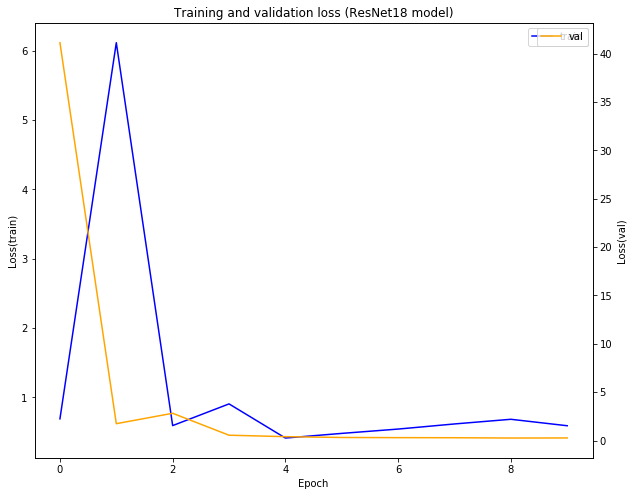

In [25]:
# TODO: plot the training and validation loss histories of ResNet18 separately
#       Don't forget proper axis labels and titles.
title = 'Training and validation loss (ResNet18 model)'
labels = ['train','val']
_, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

ax1.plot(train_loss_hist, color='blue', label=labels[0])
ax2.plot(val_loss_hist, color='orange', label=labels[1])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss(train)")
ax1.legend()
ax2.set_ylabel("Loss(val)")
ax2.legend()
# plt.legend()

plt.title(title)
plt.show()

In [ ]:
# TODO: execute live regression with the ResNet18 regression model using live_regression()


### Discuss the difference in performance between your custom model and the pretrained ResNet18 in the regression task. Were you able to fine tune the regression to your dataset? Which model's training and validation losses converged quicker? Why? Is there a considerable difference in inference speed between the two models?

TODO: Your answer here.

It is able to fine tune the regression to my dataset. The ResNet18 model takes more time to converge, that's maybe because of the number of parameters and the degree of non-linearity. Coustom model which has smaller size is faster on inferencing.